In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime
import os
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import dates as mdates

from funcs.ios import get_excel_sheet
from structs.res import AppRes

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [4]:
res = AppRes()
file = "ticks_20251006.xlsx"
path_excel = os.path.join("..", res.dir_collection, file)
code = "7011"
df = get_excel_sheet(path_excel, code)
df.index = pd.to_datetime([datetime.datetime.fromtimestamp(ts) for ts in df["Time"]])
df

,Time,Price,Volume
2025-10-06 09:21:18.419352,1.759710e+09,4247,10863000
2025-10-06 09:21:19.416535,1.759710e+09,4247,10863000
2025-10-06 09:21:20.421569,1.759710e+09,4221,10959400
2025-10-06 09:21:21.416831,1.759710e+09,4221,10959400
2025-10-06 09:21:22.410696,1.759710e+09,4202,11159800
...,...,...,...
2025-10-06 15:24:55.048785,1.759732e+09,4101,76987900
2025-10-06 15:24:56.056568,1.759732e+09,4101,76987900
2025-10-06 15:24:57.052796,1.759732e+09,4100,77026600
2025-10-06 15:24:58.068626,1.759732e+09,4100,77026600


## 株価そのまま

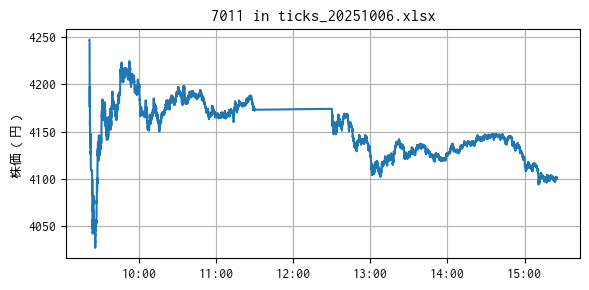

In [5]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(df["Price"])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel("株価（円）")
ax.grid()
ax.set_title(f"{code} in {file}")
plt.tight_layout()
plt.show()

## 株価比

In [6]:
price_open = df.iloc[0]["Price"]
price_open

np.float64(4247.0)

In [7]:
df["PriceRatio"] = ((df["Price"] / price_open) - 1) * 25
# df["PriceRatio"] = np.tanh(((df["Price"] / price_open) - 1) * 25)
df

,Time,Price,Volume,PriceRatio
2025-10-06 09:21:18.419352,1.759710e+09,4247,10863000,0.000000
2025-10-06 09:21:19.416535,1.759710e+09,4247,10863000,0.000000
2025-10-06 09:21:20.421569,1.759710e+09,4221,10959400,-0.153049
2025-10-06 09:21:21.416831,1.759710e+09,4221,10959400,-0.153049
2025-10-06 09:21:22.410696,1.759710e+09,4202,11159800,-0.264893
...,...,...,...,...
2025-10-06 15:24:55.048785,1.759732e+09,4101,76987900,-0.859430
2025-10-06 15:24:56.056568,1.759732e+09,4101,76987900,-0.859430
2025-10-06 15:24:57.052796,1.759732e+09,4100,77026600,-0.865317
2025-10-06 15:24:58.068626,1.759732e+09,4100,77026600,-0.865317


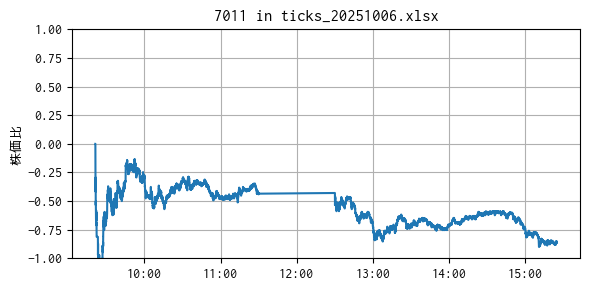

In [8]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(df["PriceRatio"])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel("株価比")
ax.set_ylim(-1, 1)
ax.grid()
ax.set_title(f"{code} in {file}")
plt.tight_layout()
plt.show()

## 制限値幅を使う → 前日終値と本日始値の平均で割る

### 前日の終値

In [9]:
# 前日のOHLC
def get_last_ohlc(file: str, code: str) -> pd.DataFrame:
    pattern = re.compile(r"ticks_(\d{4})(\d{2})(\d{2})\.xlsx")
    if m := pattern.match(file):
        yr = m.group(1)
        mo = m.group(2)
        dy = m.group(3)
    else:
        yr = "1970"
        mo = "01"
        dy = "01"
    date_end = f"{yr}-{mo}-{dy}"
    ticker = yf.Ticker(f"{code}.T")
    return ticker.history(period="10d", interval="1d", end=date_end).tail(1)

In [10]:
df_last = get_last_ohlc(file, code)
df_last

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-10-03 00:00:00+09:00,3693.0,3733.0,3648.0,3690.0,20747500,0.0,0.0


In [11]:
price_lastclose = int(df_last.iloc[0]["Close"])
price_lastclose

3690

In [107]:
df.iloc[0]["Price"] - price_lastclose

np.float64(557.0)

In [101]:
file_price_limit = "tse_daily_price_limit.csv"
path_csv = os.path.join("..", res.dir_info, file_price_limit)
df_price_limit = pd.read_csv(path_csv)
df_price_limit

,price_max,range
0,100,30
1,200,50
2,500,80
3,700,100
4,1000,150
5,1500,300
6,2000,400
7,3000,500
8,5000,700
9,7000,1000


In [102]:
price_range = (
    df_price_limit[df_price_limit["price_max"] >= price_lastclose]
    .head(1)
    .iloc[0]["range"]
)
price_range

np.int64(700)

In [103]:
df["PriceNorm"] = (df["Price"] - price_lastclose) / price_range * 10
df["PriceNorm"].min(), df["PriceNorm"].max()

(np.float64(4.814285714285714), np.float64(7.957142857142857))

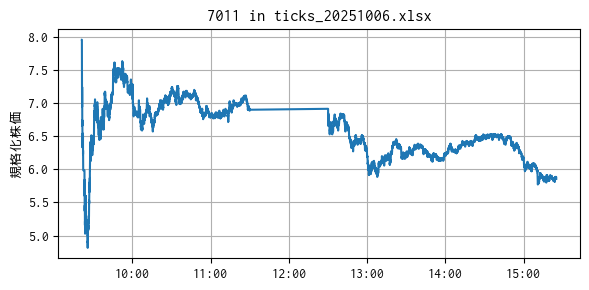

In [109]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(df["PriceNorm"])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel("規格化株価")
# ax.set_ylim(-1, 1)
ax.grid()
ax.set_title(f"{code} in {file}")
plt.tight_layout()
plt.show()

## 始値からどの程度変動するのか？

In [20]:
df_summary = pd.DataFrame(
    {
        "file": [],
        "mean": [],
        "std": [],
        "min": [],
        "max": [],
        "range": [],
    }
)
code = "7011"
files = sorted(os.listdir(os.path.join("..", res.dir_collection)))
for file in files:
    # print(file, end=" : ")
    path_excel = os.path.join("..", res.dir_collection, file)
    code = "7011"
    df = get_excel_sheet(path_excel, code)
    df.index = pd.to_datetime(
        [datetime.datetime.fromtimestamp(ts) for ts in df["Time"]]
    )
    price_open = df.iloc[0]["Price"]

    # 前日の終値
    df_last = get_last_ohlc(file, code)
    price_lastclose = int(df_last.iloc[0]["Close"])

    df["PriceRatio"] = (df["Price"] / price_lastclose) - 1
    r = len(df_summary)
    df_summary.loc[r] = [
        file,
        df["PriceRatio"].mean(),
        df["PriceRatio"].std(),
        df["PriceRatio"].min(),
        df["PriceRatio"].max(),
        df["PriceRatio"].max() - df["PriceRatio"].min(),
    ]

In [21]:
df_summary

,file,mean,std,min,max,range
0,ticks_20250819.xlsx,-0.003223,0.004787,-0.014721,0.024365,0.039086
1,ticks_20250820.xlsx,-0.018518,0.002913,-0.030576,-0.011562,0.019013
2,ticks_20250821.xlsx,-0.000320,0.002949,-0.007085,0.013382,0.020467
3,ticks_20250822.xlsx,0.010109,0.003770,0.004216,0.017918,0.013702
4,ticks_20250825.xlsx,0.000749,0.002510,-0.002625,0.017065,0.019690
5,ticks_20250826.xlsx,-0.004485,0.004300,-0.008959,0.010277,0.019236
6,ticks_20250827.xlsx,0.003327,0.002826,-0.001866,0.014392,0.016258
7,ticks_20250828.xlsx,0.009123,0.005000,-0.012006,0.015475,0.027481
8,ticks_20250829.xlsx,-0.005786,0.003430,-0.010821,0.005278,0.016099
9,ticks_20250901.xlsx,0.002516,0.009455,-0.009088,0.028335,0.037423


In [23]:
df_summary["mean"].mean(), df_summary["mean"].std()

(np.float64(0.006067327052845944), np.float64(0.0230816094135015))